In [2]:
import pickle
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import pandas as pd
import jieba
from keras.utils import to_categorical 

def convert_to_chinese(number):
    chinese_numerals = {
        "0": "零",
        "1": "一",
        "2": "二",
        "3": "三",
        "4": "四",
        "5": "五",
        "6": "六",
        "7": "七",
        "8": "八",
        "9": "九",
    }
    chinese_number = "".join([chinese_numerals[str(digit)] for digit in str(number)])
    return chinese_number

# 定義將文本中的阿拉伯數字轉換為中文數字的函數
def convert_numbers_to_chinese(text):
    # 確保text是字符串，如果不是，轉換為字符串
    text = str(text)
    words = jieba.lcut(text)
    converted_words = ''.join([convert_to_chinese(word) if word.isdigit() else word for word in words])
    return converted_words



# 載入第一個程式產生的檔案
with open("tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

word2vec_model = Word2Vec.load("word2vec.model")
embedding_dim = word2vec_model.vector_size  # 取得Word2Vec模型的維度
vocab_list = [word for word,i in word2vec_model.wv.key_to_index.items()]  # 取得
word_index = {" ":0}
word_vector = {}


# 將文本轉換成詞向量
embedding_matrix = np.zeros((len(vocab_list) + 1, embedding_dim))
for i in range(len(vocab_list)):
    word = vocab_list[i]
    word_index[word] = i + 1
    word_vector[word] = word2vec_model.wv[word]
    embedding_matrix[i + 1] = word2vec_model.wv[word]

2023-12-27 16:41:52.423983: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-27 16:41:52.446517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 16:41:52.446547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 16:41:52.446564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 16:41:52.451054: I tensorflow/core/platform/cpu_feature_g

In [3]:
data = pd.read_excel('train_data.xlsx')

# 將 "輸入" 欄位中的阿拉伯數字轉換為中文數字
data["輸入"] = data["輸入"].apply(convert_numbers_to_chinese)
# 資料預處理（假設已有資料X和標籤y）
X = []
y = []
for i in range(len(data)):
    X.append(jieba.lcut(data["輸入"].iloc[i]))
    y.append(data["分類"].iloc[i])
y_cate = to_categorical(np.asarray(y))


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.233 seconds.
Prefix dict has been built succesfully.


In [6]:
def tokenizer(text, word_index):
    data = []
    for sentence in text:
        new_text = []
        for word in sentence:
            if word in word_index:
                try:
                    new_text.append(word_index[word])
                except:
                    new_text.append(0)
        data.append(new_text)
    data_lengths = [len(sentence) for sentence in data]
    max_length = max(data_lengths)
    
    texts = pad_sequences(data, maxlen=7)
    return texts
with open('word_index.pkl', 'wb') as f:
    pickle.dump(word_index, f)
X = tokenizer(X, word_index)

In [5]:
# 切割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y_cate, test_size=0.2, random_state=42)
word_index
# X_train = X
# y_train = y

{' ': 155,
 '？': 1,
 '的': 2,
 '，': 3,
 '我': 4,
 '嗎': 5,
 '。': 6,
 '時間': 7,
 '包裹': 8,
 '是': 9,
 '可以': 10,
 '查詢': 11,
 '有': 12,
 '物流': 13,
 '新竹': 14,
 '營業': 15,
 '沒': 16,
 '會': 17,
 '服務': 18,
 '貨物': 19,
 '了': 20,
 '派送': 21,
 '在': 22,
 '請問': 23,
 '什麼': 24,
 '客服': 25,
 '哪裡': 26,
 '送達': 27,
 '營業所': 28,
 '送貨': 29,
 '時候': 30,
 '何時': 31,
 '哪': 32,
 '地址': 33,
 '需要': 34,
 '如何': 35,
 '今天': 36,
 '配送': 37,
 '不': 38,
 '人': 39,
 '通知': 40,
 '多久': 41,
 '些': 42,
 '送到': 43,
 '幾': 44,
 '一': 45,
 '根本': 46,
 '提供': 47,
 '都': 48,
 '想': 49,
 '貨件': 50,
 '據點': 51,
 '怎麼': 52,
 '收到': 53,
 '要': 54,
 '現在': 55,
 '沒有': 56,
 '真的': 57,
 '和': 58,
 '中': 59,
 '運送': 60,
 '時': 61,
 '到': 62,
 '一直': 63,
 '狀態': 64,
 '地點': 65,
 '站所': 66,
 '能': 67,
 '一下': 68,
 '方式': 69,
 '買': 70,
 '提前': 71,
 '/': 72,
 '問題': 73,
 '個': 74,
 '後': 75,
 '進度': 76,
 '商品': 77,
 '好': 78,
 '那裡': 79,
 '確認': 80,
 '次': 81,
 '點': 82,
 '還': 83,
 '已經': 84,
 '電話': 85,
 '真人': 86,
 '人工': 87,
 '告訴': 88,
 '司機': 89,
 '情況': 90,
 '?': 91,
 '明明': 92,
 '到貨': 93,
 '知道': 94

訓練(lstm)

In [ ]:
from keras.models import Sequential, save_model
from keras.layers import Embedding, Bidirectional, LSTM, BatchNormalization, Dense, Dropout
from keras.optimizers import Adam
from keras.constraints import max_norm
from keras.initializers import he_normal
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from datetime import datetime
# 創建模型
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                    weights=[embedding_matrix], input_length=X.shape[1], 
                    trainable=False, embeddings_initializer=he_normal()))
model.add(Bidirectional(LSTM(64, return_sequences=True, 
                             kernel_constraint=max_norm(5), kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(32, kernel_constraint=max_norm(5), kernel_regularizer=l2(0.01))))
model.add(Dropout(0.3))  # 添加 Dropout 層，可根據需要調整 dropout 比例
model.add(Dense(6, activation='softmax', kernel_regularizer=l2(0.01)))  # 在全連接層上應用 L2 正規化

# 編譯模型，使用學習率調整器
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# 訓練模型，加入 callbacks
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Generate today's date in the format YYYYMMDD
today_date = datetime.today().strftime('%Y%m%d')

# Construct the filename using the specified naming convention
filename = f'LSTMmodel_{today_date}.keras'

# Save the entire model in the .keras format with the constructed filename
# save_model(model, filename)
filename

訓練(bigru early stop)

In [100]:
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, save_model
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
import numpy as np
from keras.regularizers import l2
from datetime import datetime

# Create the Sequential model
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                    weights=[embedding_matrix], input_length=X.shape[1], 
                    trainable=False))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

# Compile the model with categorical crossentropy loss and Adam optimizer with specified learning rate
# Also, include accuracy as a metric
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model using the training data and validate on the test data
# Include the ReduceLROnPlateau and EarlyStopping callbacks
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stop])

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X, y_cate, epochs=80, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[reduce_lr,early_stop])

# Generate today's date in the format YYYYMMDD
today_date = datetime.today().strftime('%Y%m%d')

# Construct the filename using the specified naming convention
filename = f'BiLSTMmodel_{today_date}.keras'

# Save the entire model in the .keras format with the constructed filename
save_model(model, filename)


Epoch 1/80
5/5 [==============================] - 9s 403ms/step - loss: 17.3439 - accuracy: 0.2821 - val_loss: 17.0489 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/80
5/5 [==============================] - 0s 52ms/step - loss: 16.8286 - accuracy: 0.4357 - val_loss: 16.7850 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/80
5/5 [==============================] - 0s 46ms/step - loss: 16.3856 - accuracy: 0.4179 - val_loss: 16.4840 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/80
5/5 [==============================] - 0s 48ms/step - loss: 15.9368 - accuracy: 0.4786 - val_loss: 16.1743 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/80
5/5 [==============================] - 0s 46ms/step - loss: 15.5194 - accuracy: 0.4464 - val_loss: 15.8478 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/80
5/5 [==============================] - 0s 48ms/step - loss: 15.1247 - accuracy: 0.4857 - val_loss: 15.5198 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/80
5/5 [==============================] - 0

訓練(NN)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM

from keras.layers import Dropout
Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=X.shape[1], 
                                trainable=False)
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=X.shape[1], 
                                trainable=False))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))  # 新增一層 LSTM
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 打印模型摘要
model.summary()
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, MultiHeadAttention, Embedding, Flatten, LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.layers import concatenate

# 修改 create_model_with_self_attention 函數
def create_model_with_attention_and_lstm(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']):
    inputs = Input(shape=(X.shape[1],))
    
    # 添加嵌入層，使用預訓練的嵌入矩陣
    embedding_layer = Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=X.shape[1], 
                                trainable=False)(inputs)
    
    # 添加自注意力機制（self-attention）
    attention = MultiHeadAttention(num_heads=1, key_dim=50)(embedding_layer, embedding_layer, embedding_layer)
    
    # Flatten 注意力的輸出
    attention_flatten = Flatten()(attention)
    
    # LSTM 層
    lstm_layer = LSTM(64)(embedding_layer)
    
    # 將自注意力的輸出和LSTM的輸出連接
    merged_layer = concatenate([attention_flatten, lstm_layer])
    
    # 全連接層
    dense_layer = Dense(64, activation='relu')(merged_layer)
    batch_norm = BatchNormalization()(dense_layer)
    dropout = Dropout(0.3)(batch_norm)
    
    # 輸出層，使用 softmax 激活函數
    output_layer = Dense(6, activation='softmax')(dropout)
    
    # 創建模型
    model = Model(inputs=inputs, outputs=output_layer)
    
    # 編譯模型
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# 使用最佳學習率創建具有自注意力機制的模型
model_with_self_attention = create_model_with_attention_and_lstm()

# 生成當天日期的字符串
today_date = datetime.today().strftime('%Y%m%d')

# 構建文件名，使用指定的命名慣例
filename = f'NNmodel_{today_date}.tf'

# 建立 ModelCheckpoint 回調以保存最佳模型
checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model_with_self_attention.summary()
# 模型訓練
model_with_self_attention.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])


In [ ]:
# print('X.shape:',X.shape)
print('y.shape:',y.shape)
y_train[1]

In [ ]:
# 假設X是你的文本數據，已經通過tokenizer轉換為數字序列

# 計算每個句子的長度
sentence_lengths = [len(sentence) for sentence in X]

# 計算平均數
average_length = sum(sentence_lengths) / len(sentence_lengths)

# 計算中位數
sorted_lengths = sorted(sentence_lengths)
mid = len(sorted_lengths) // 2
median_length = (sorted_lengths[mid] + sorted_lengths[~mid]) / 2  # 使用~mid取得中位數，即使數量為奇數也可正確計算

# 打印結果
print(f"平均數: {average_length}")
print(f"中位數: {median_length}")


訓練(cnn attention)

Epoch 1/80
5/5 [==============================] - 12s 407ms/step - loss: 17.6936 - accuracy: 0.2179 - val_loss: 16.9726 - val_accuracy: 0.1127
Epoch 2/80
5/5 [==============================] - 0s 46ms/step - loss: 16.7922 - accuracy: 0.3857 - val_loss: 16.7310 - val_accuracy: 0.0000e+00
Epoch 3/80
5/5 [==============================] - 0s 48ms/step - loss: 16.2784 - accuracy: 0.4607 - val_loss: 16.4717 - val_accuracy: 0.0000e+00
Epoch 4/80
5/5 [==============================] - 0s 46ms/step - loss: 15.9287 - accuracy: 0.4393 - val_loss: 16.1960 - val_accuracy: 0.0000e+00
Epoch 5/80
5/5 [==============================] - 0s 47ms/step - loss: 15.5829 - accuracy: 0.5179 - val_loss: 15.9013 - val_accuracy: 0.0000e+00
Epoch 6/80
5/5 [==============================] - 0s 48ms/step - loss: 15.2340 - accuracy: 0.5143 - val_loss: 15.5956 - val_accuracy: 0.0000e+00
Epoch 7/80
5/5 [==============================] - 0s 49ms/step - loss: 14.8251 - accuracy: 0.5214 - val_loss: 15.2874 - val_accuracy

Minimum Validation Loss: 3.6029


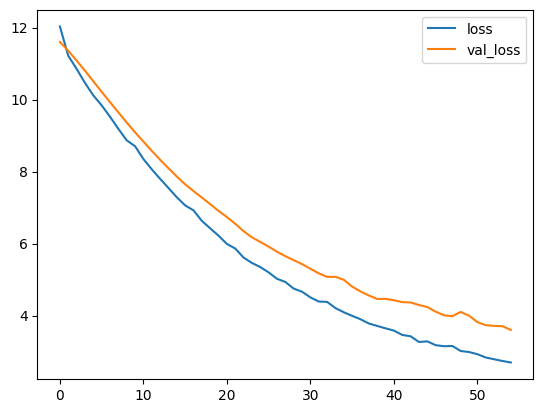

In [71]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Minimum Training Loss: 3.2051
Minimum Validation Loss: 4.3712
Maximum Training Accuracy: 0.8107
Maximum Validation Accuracy: 0.5775


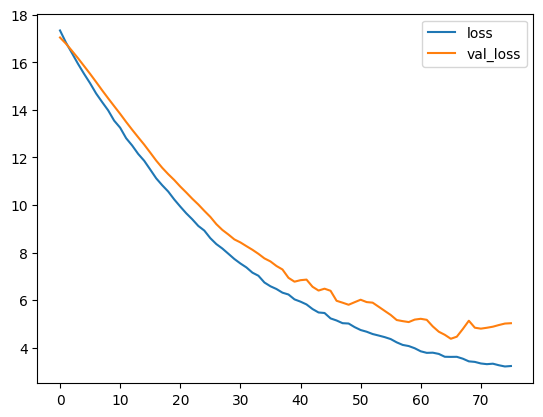

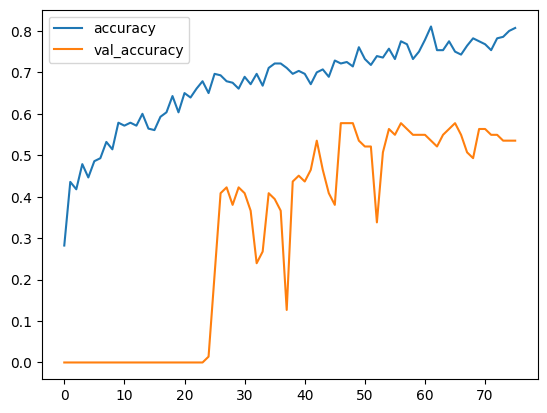

In [102]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Training Loss: {:0.4f}").format(history_df['loss'].min()))
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()
print(("Maximum Training Accuracy: {:0.4f}").format(history_df['accuracy'].max()))
print(("Maximum Validation Accuracy: {:0.4f}").format(history_df['val_accuracy'].max()))